In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sympy as sp
import numpy as np
import control as ctl

# OBTENDO DADOS

In [2]:
df = pd.read_csv('DataBase.csv')
print('size:', len(df))
df.head()

size: 15000


,time,input,output
0,0.000000,50.0,0.000000
1,0.000467,50.0,-0.012376
2,0.000933,50.0,0.017691
3,0.001400,50.0,0.039704
4,0.001867,50.0,0.097024


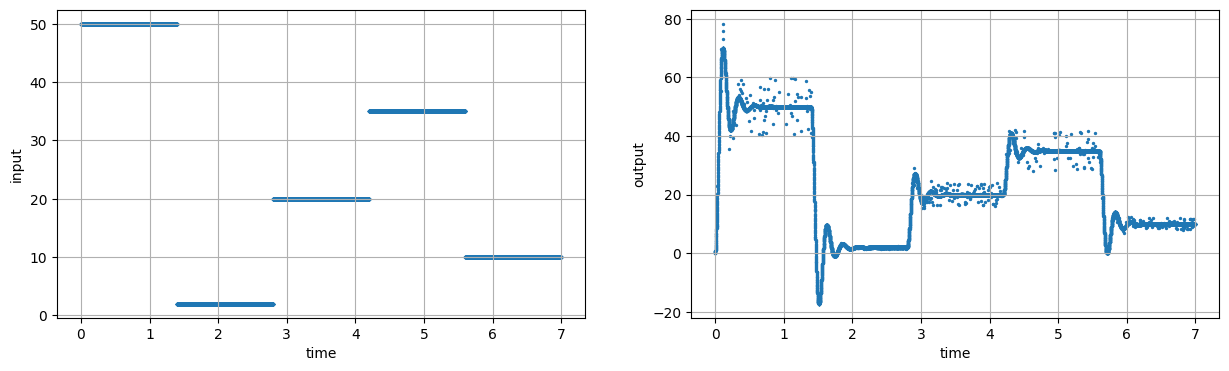

In [3]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.scatter(df.time, df.input, s=2)
plt.xlabel('time'), plt.ylabel('input')
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(df.time, df.output, s=2)
plt.xlabel('time'), plt.ylabel('output')
plt.grid()

# PADRONIZANDO OS DADOS

In [4]:
def normalizeData(df, timeKey, responseKey, T=0.15):
    initTime  = df[timeKey].iloc[0]
    finalTime = df[timeKey].iloc[-1] + T
    timeData = np.arange(initTime, finalTime, T)
    
    lastValue  = df[responseKey].iloc[0]
    desired = []

    for t in timeData:
        filtered = df.loc[df[timeKey] <= t][responseKey]
        
        if not filtered.empty:
            lastValue = filtered.iloc[-1]
        
        desired.append(lastValue)
    
    return timeData, desired


def normalizeTable(df, key, T=0.15):
    table = {key: []}

    for column in df.columns:
        if column == key:
            continue

        xData, yData = normalizeData(df, key, column, T)
        table[column] = yData

    table[key] = xData
    return pd.DataFrame(table) 


T = 0.001
df = normalizeTable(df, 'time', T)
print('size:', len(df))
df.head()

size: 7001


,time,input,output
0,0.000,50.0,0.000000
1,0.001,50.0,0.017691
2,0.002,50.0,0.097024
3,0.003,50.0,0.121649
4,0.004,50.0,0.302253


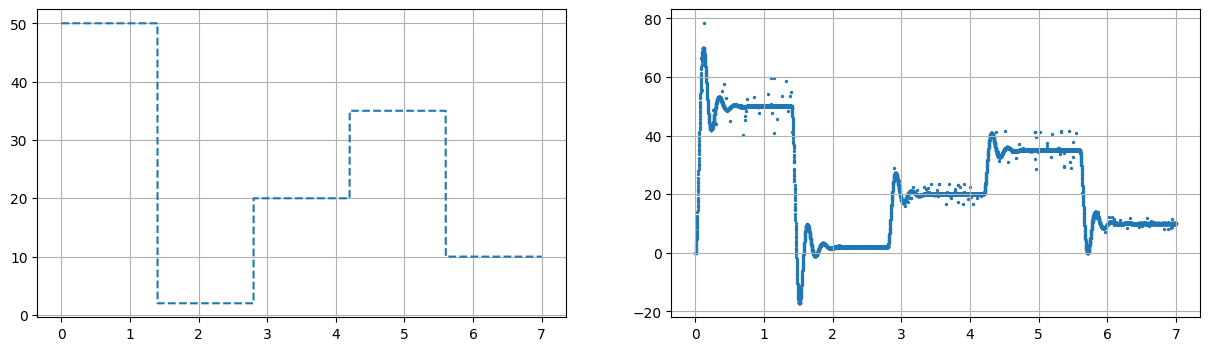

In [5]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(df.time, df.input, '--')
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(df.time, df.output, s=2)
plt.grid()

In [6]:
tData, uData, yData = df.time.values, df.input.values, df.output.values

# FILTRANDO OS DADOS
- **Filtro de Savitzky-Golay**: Este filtro ajusta um polinômio de baixa ordem a uma janela deslizante de pontos de dados, preservando a forma geral dos dados (como picos e vales) enquanto suaviza o ruído. Ideal para preservar as características da curva.

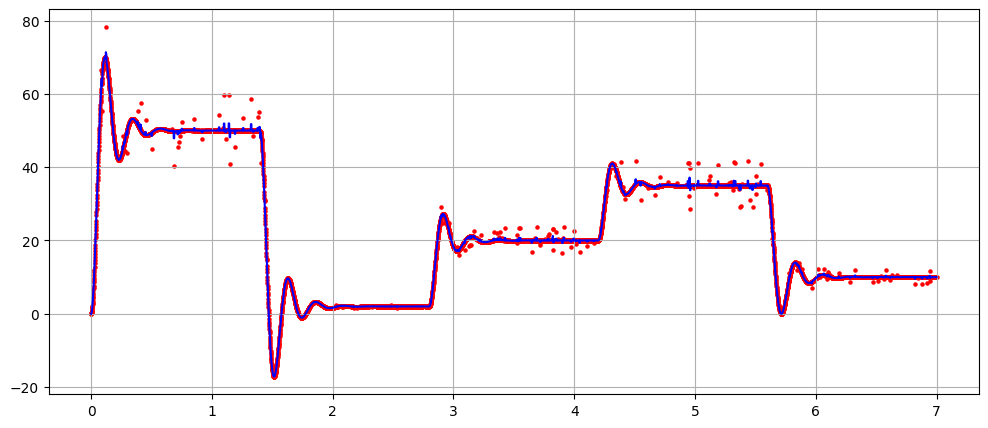

In [ ]:
from scipy.signal import savgol_filter
yGolay= savgol_filter(yData, window_length=5, polyorder=1)
plt.figure(figsize=(12, 5))
plt.scatter(tData, yData, s=5, color='red')
plt.plot(tData, yGolay, color='blue')
plt.grid()

- **Filtro de Média Móvel**: Esse é um filtro simples e eficaz, que substitui cada ponto de dados pela média dos pontos em uma janela móvel.

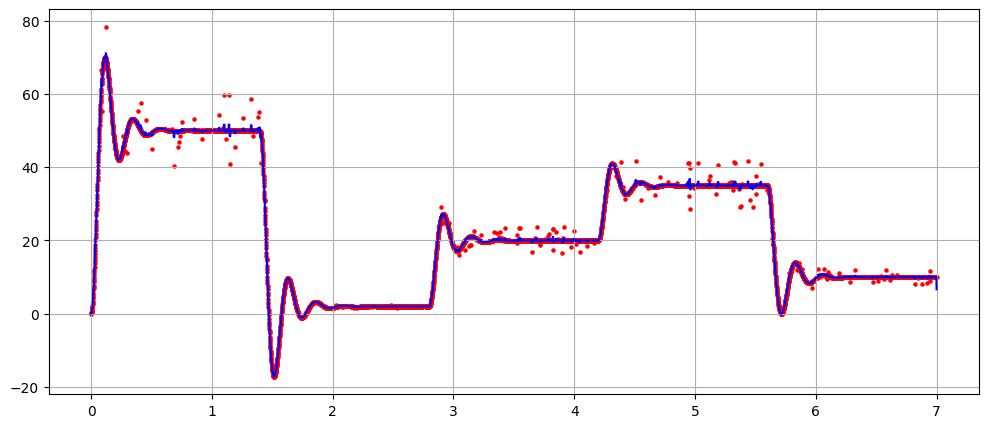

In [ ]:
from numpy import convolve
windowSize = 6
yMean = convolve(yData, np.ones(windowSize) / windowSize, mode='same')

plt.figure(figsize=(12, 5))
plt.scatter(tData, yData, s=5, color='red')
plt.plot(tData, yMean, color='blue')
plt.grid()

- **Filtro Gaussiano**: Esse filtro aplica uma função gaussiana aos dados em uma janela, o que resulta em uma suavização mais natural e contínua.

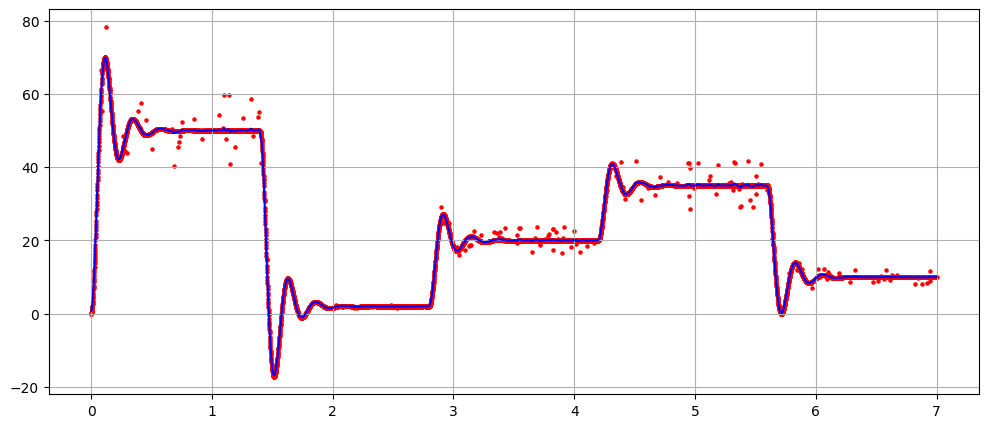

In [ ]:
from scipy.ndimage import gaussian_filter
yGaussian = gaussian_filter(yData, sigma=7)

plt.figure(figsize=(12, 5))
plt.scatter(tData, yData, s=5, color='red')
plt.plot(tData, yGaussian, color='blue')
plt.grid()

- **Filtro de Média Exponencial**: Esse método dá mais peso aos valores mais recentes, o que é útil para séries temporais.

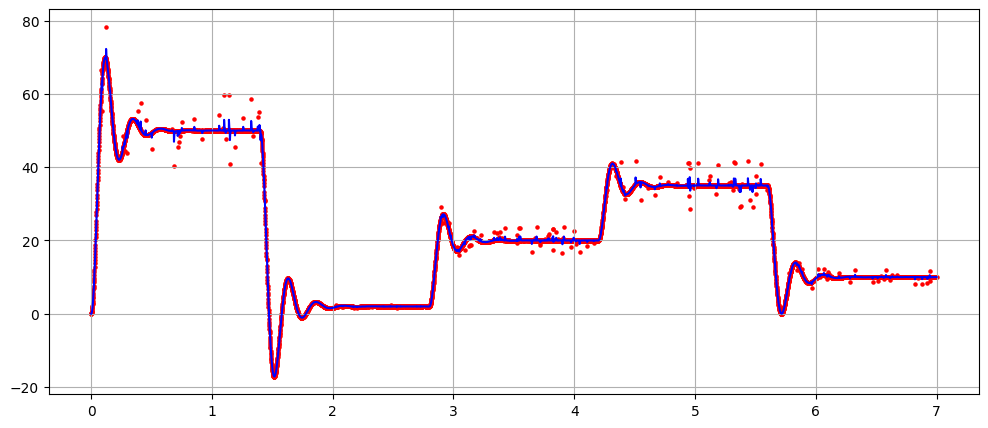

In [10]:
yExpon = pd.Series(yData).ewm(alpha=0.3).mean().to_numpy()

plt.figure(figsize=(12, 5))
plt.scatter(tData, yData, s=5, color='red')
plt.plot(tData, yExpon, color='blue')
plt.grid()

- **Filtro de Butterworth**: É um filtro passa-baixas que elimina componentes de alta frequência e é muito usado para sinais onde queremos eliminar ruídos de alta frequência.

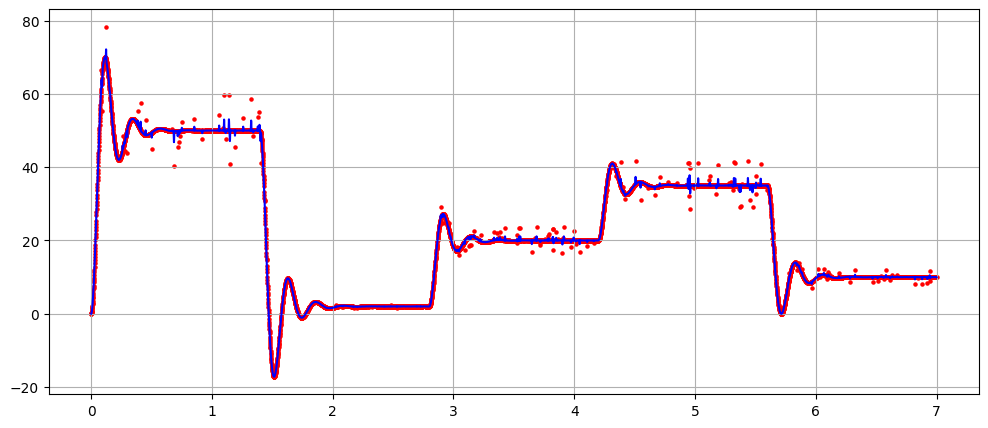

In [11]:
from scipy.signal import butter, filtfilt

order = 2           # Ordem do filtro
cutoff_freq = 0.3  # Frequência de corte (ajuste conforme seu sinal)
b, a = butter(order, cutoff_freq, btype='low', analog=False)
yButterworth = filtfilt(b, a, yData)

plt.figure(figsize=(12, 5))
plt.scatter(tData, yData, s=5, color='red')
plt.plot(tData, yButterworth, color='blue')
plt.grid()

**Escolhendo o Filtro de Melhor Desempenho**

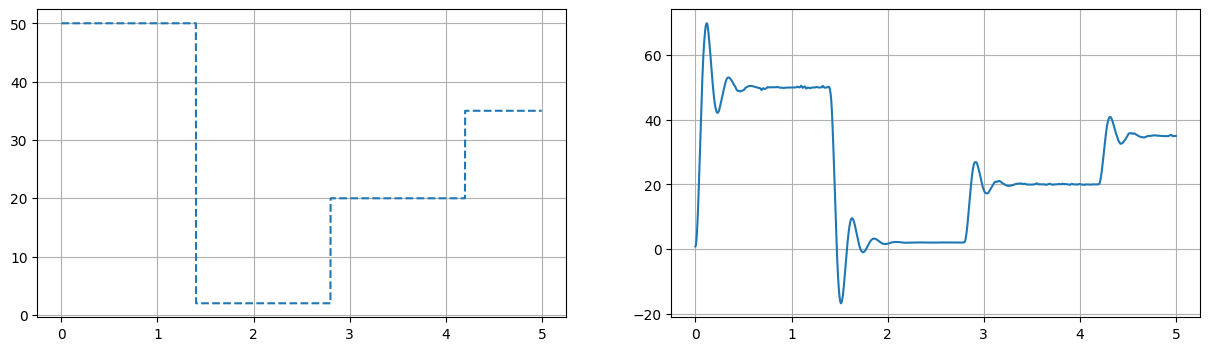

In [12]:
df['output'] = yGaussian
df = df.loc[df.time < 5]

plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(df.time, df.input, '--')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(df.time, df.output)
plt.grid()

# DATA FITTING
O gráfico expressa a função de transferência no domínio do tempo $Y(s) = L^{-1}\{y(t)\}$, podemos encontrar $y(t)$ usando data fitting, encontrando uma função própria que se encaixe nos dados

In [ ]:
tData, uData, yData = df.time.values, df.input.values, df.output.values

In [14]:
def g(u, a, b, c):
    s = ctl.TransferFunction.s
    G = a/(s**2 + b*s + c)
    return ctl.forced_response(G, T=tData, U=u)[1]

def getFunction(xDados, yDados):
    coeficientes = curve_fit(g, xDados, yDados, maxfev=1000000000)  # MÁXIMO DE ITERAÇÕES
    return list(coeficientes[0])

In [15]:
coefs = getFunction(uData, yData)  
coefs

[815.5205397668972, 16.220488042162156, 815.5839455207803]

In [16]:
s = ctl.TransferFunction.s
a, b, c = coefs

G = a/(s**2 + b*s + c)
G

TransferFunction(array([815.52053977]), array([  1.        ,  16.22048804, 815.58394552]))

### CONFERINDO COM A DATABASE

In [17]:
df = pd.read_csv('DataBase.csv')
tData, uData, yData = df.time.values, df.input.values, df.output.values

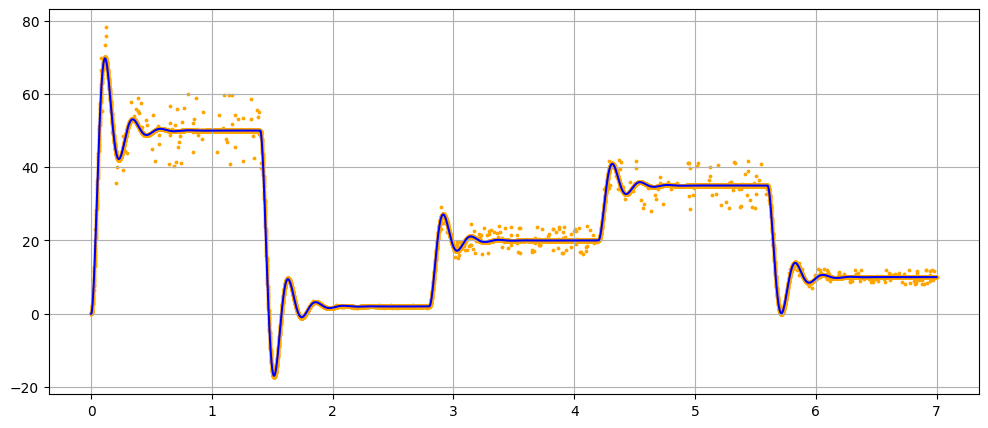

In [18]:
time, response = ctl.forced_response(G, T=tData, U=uData)

plt.figure(figsize=(12, 5))
plt.plot(time, response, color='blue')
plt.scatter(time, yData, color='orange', s=3)
plt.grid()

In [19]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=4):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

print(sympyFunction(G))

815.520539766897/(1.0*s**2 + 16.2204880421622*s + 815.58394552078)
